## Authors:

###Lloyd Linton Jones
###Ihona Maria Correa de Cabo

# Laboratory : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**
* This lab must be worked in pairs. Make sure that when you submit your lab you change the name to: **08_lab_Student1FullName_Student2FullName.ipynb**

---

*This code is adapted from [this tutorial](https://keras.io/examples/vision/vit_small_ds)*

# Vision Transformers [1 Point]

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   1.What are the differences between CNN and Transformers?
*   2.What is Multi-head self-attention?
*   3.What is Inductive Bias?

**Solution**

1.  CNN use convolutional layers to extract local features and progressively learn features from local to global. On the other hand, transformers use self-attention to model the global relationships between all the input elements.
They process the input as a sequence, treating image patches like tokens in NLP.
Moreover, transformers require larger datasets and pre-training to achieve better performance, wherease  CNNs perform well on smaller datasets due to the inductive biases (see answer 3).

2. Multi-Head Self-Attention is a way for the model to focus on different parts of an input (like an image or sentence) at the same time, thus enhancing the ability to capture diverse relationships in the data. For each token, self-attention computes a weighted sum of all tokens, where the weights (or attention scores) represent the relevance of other tokens. In the multi-head mechanism, however,instead of a single attention computation, multiple attention heads are computed in parallel.

3. Inductive bias refers to the assumptions that a model makes about the underlying data distribution in order to generalize better from limited data.
For example, CNNs assume that images have patterns like edges and textures that are consistent across different parts of the image. This is why they work well with smaller datasets, because they already "know" to look for these patterns, like a shortcut to learning. Therefore, in an easy way, inductive bias is the set of helpful assumptions a model starts with to make learning easier.
Transformers, on the other hand, have minimal inductive bias since they treat the input as a sequence.They require large datasets because this enables them to learn patterns directly from data rather than relying on predefined assumptions.

*   Explain the model architecture of ViT.

**Solution**<br>
The Vision Transformer (ViT) adapts the Transformer architecture, originally designed for natural language processing, to image recognition tasks by treating an image as a sequence of patches. The model first divides an image into fixed-size patches (e.g., 16x16 pixels), flattens each patch, and applies a linear projection to create patch embeddings. These embeddings are combined with learnable positional embeddings to retain spatial information and are then input into a standard Transformer encoder.

The Transformer encoder consists of alternating layers of multi-head self-attention (MSA) and feed-forward neural networks (MLPs), with residual connections and layer normalization applied at each step. An additional learnable classification token ([CLS]) is prepended to the sequence, and its final state serves as the image representation for downstream tasks. Unlike convolutional neural networks (CNNs), ViT relies on global self-attention, allowing it to model long-range dependencies across the entire image.

# 1. Implementation of ViT with CIFAR-100: Tutorial and Questions [2 points]

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


## Setup
For this exercise, we require TensorFlow 2.4 or higher

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the Hyper-parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # Resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
LAYER_NORM_EPS = 1e-6

## Data Augmentation Pipeline

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement a Multi-layer Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


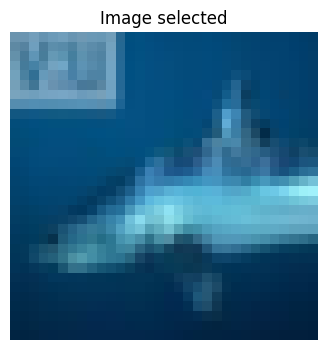

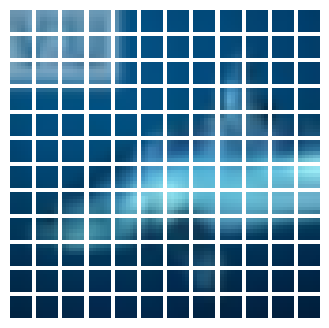

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.title("Image selected")
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.show()

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**

The patch encoding layer prepares the image patches so they can be inputed to the Transformer. Each patch is flattened into a list of numbers, and the Patch Encoding Layer transforms this list into a richer representation, so the Transformer can understand better the content of each patch. Moreover, since the Transformer doesn’t know where each patch came from in the image, the Patch Encoding Layer includes information about the position of each patch. This helps the model understand how patches are arranged in the image.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

In summary, the call function of the PatchEncoder class does the following:

- Position Generation: It creates a sequence representing the positions of the patches.
- Patch Projection: Transforms the patches into a higher-dimensional space using a dense layer.
- Add Positional Embeddings: Adds positional information to each patch using embeddings.
- Output Encoded Patches: Returns the enriched patch representations with both visual features and spatial context.



## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

**Questions**
*   1. Explain the execution of the ViT model. What is the sequence of operations?
*   2. What is skip connection? Why is it needed?

**Solution**

* 1.
    * a. Input data and data augmentation
    * b. Create patches
    * c. Endcode patches
    * d. Appy transformer layers
    * e. Classify the output patches from the transformer using MLP and then final softmax layer
* 2. A skip connection (also known as a residual connection) adds the input of a layer directly to the output of a subsequent layer. In the ViT model, the outputs from the multi-head attention and MLP layers are added to the original inputs using skip connections.<br>
  * Enhances feature learning
  * Prevents vanishing gradients
  * Improves convergence

**Questions**
*   3. What is self-attention?
*   4. What is the problem in using global self-attention?
*   5. What can be used instead of global self-attention?

**Solution**

* 3. Self attention is a mechanism that allows the model to focus on different parts of the input to determine their reletionships and relevance. In this context,it helps each image patch "pay attention" to other patches, capturing dependencies and patterns globally, no matter of their position in the image.

* 4. Global self-attention requires comparing every patch to every other patch, so it is very computational expensive. As the image size increases, the number of patches grows, making this approach not appealing for high-resolution images, it's not scalable.

* 5. Among other possibilities, local attention could be used instead of global self-attention. In this case, local attention focuses only on nearby patches, therefore reducing some computational costs while at the same time maintaining essential context for image understanding. Due to its nature, it works well for tasks where most important information comes from nearby regions.


## Training the ViT Model

In [ ]:
def run_experiment(model):
    optimizer = tf.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 427ms/step - accuracy: 0.0277 - loss: 4.9167 - top-5-accuracy: 0.1065 - val_accuracy: 0.0964 - val_loss: 4.0209 - val_top-5-accuracy: 0.2782
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 396ms/step - accuracy: 0.0782 - loss: 4.0649 - top-5-accuracy: 0.2579 - val_accuracy: 0.1510 - val_loss: 3.5979 - val_top-5-accuracy: 0.3922
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 401ms/step - accuracy: 0.1180 - loss: 3.7828 - top-5-accuracy: 0.3409 - val_accuracy: 0.1916 - val_loss: 3.3623 - val_top-5-accuracy: 0.4818
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 427ms/step - accuracy: 0.1460 - loss: 3.5782 - top-5-accuracy: 0.4007 - val_accuracy: 0.2144 - val_loss: 3.2210 - val_top-5-accuracy: 0.5108
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 392ms/step - accuracy: 0.1772 - loss: 3.4274 - top-5-accuracy: 0.4394 - val_accuracy: 0.2460 - val_loss: 3.0729 - val_top-5-accuracy: 0.5328
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.1988 

**1.1 Create loss plots with both train and validation values**

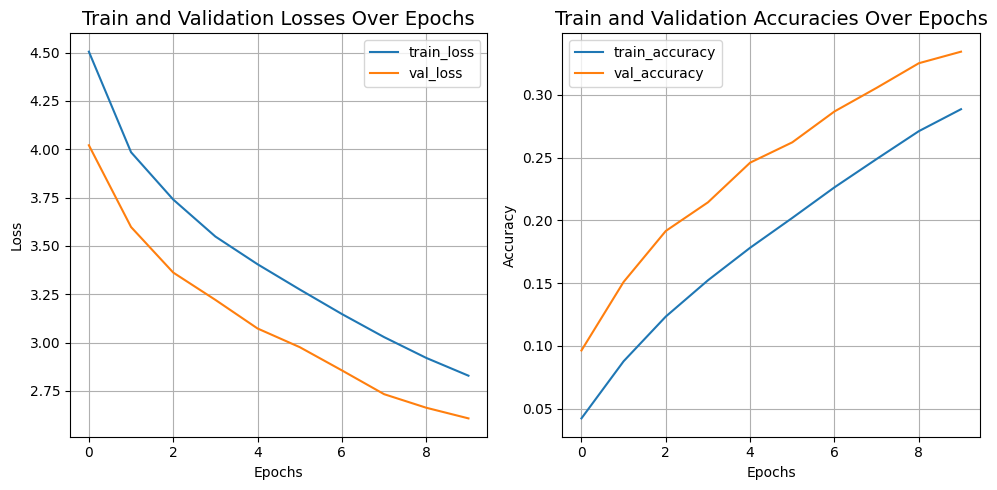

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history["loss"], label="train_loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train and Validation Losses Over Epochs", fontsize=14)
ax[0].legend()
ax[0].grid()
ax[1].plot(history.history["accuracy"], label="train_accuracy")
ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Train and Validation Accuracies Over Epochs", fontsize=14)
ax[1].legend()
ax[1].grid()
fig.tight_layout()
plt.show()

**1.2 Evaluating the trained ViT transformer**

vit_classifier.evaluate can be used for this. It will return three values: loss, accuracy and top 5 accuracy. Print the accuracy ones for the test set

In [ ]:
#solution
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3399 - loss: 2.5787 - top-5-accuracy: 0.6486
Test loss: 2.58
Test accuracy: 33.87%
Test top 5 accuracy: 64.75%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

---
This has been done for you, noice the parts of the ShiftedPatchTokenization class:
*   The class has an __init__(), call() and crop_shift_pad functions
*   crop_shift_pad with shift operations of the type: left-up, right-up, left-down and right-down and no shift.


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            #Original
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=num_patches, projection_dim=projection_dim, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

**1.3 Visualize the patches for a random image**

Similar to the previous one, visualize the new patches with the ShiftedPatchTokenization, you can use vanilla=True version on this. Notice that this will return you 2 values, token and patch. You would like to use patch for the visualization.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


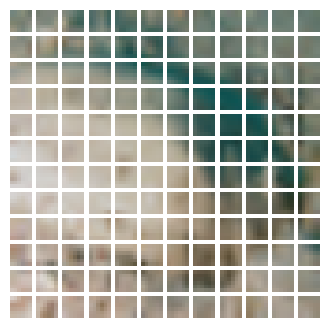

In [ ]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()


## Build the ViT model

Creating the ViT classifier by replacing the Patch Layer with the Shifted Patch Layer

In [ ]:
def create_vit_classifier_SP():
    inputs = layers.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    (tokens, _) = ShiftedPatchTokenization(vanilla=True)(augmented)

    # Encode patches
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


**1.4 Compile and train the classifier**

Your model can be created with create_vit_classifier_SP and then use run_experiment to perform the training. Save your results in an object to later access the saved loss and accuracies.

In [ ]:
# solution
vit_classifier_2 = create_vit_classifier_SP()
print(vit_classifier_2.summary())
history_2 = run_experiment(vit_classifier_2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 72, 72, 3)      │              7 │ input_layer_5[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shifted_patch_tokenizati… │ [(None, 144, 64),      │          6,976 │ data_augmentation[1][… │
│ (ShiftedPatchTokenizatio… │ (None, 12, 12, 108)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_3           │ (None, 144, 64)        │          9,216 │ shifted_patch_tokeniz… │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_55    │ (None, 144, 64)        │            128 │ patch_encoder_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 144, 64)        │         66,368 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_48 (Add)              │ (None, 144, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_56    │ (None, 144, 64)        │            128 │ add_48[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 144, 128)       │          8,320 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_82 (Dropout)      │ (None, 144, 128)       │              0 │ dense_63[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 144, 64)        │          8,256 │ dropout_82[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_83 (Dropout)      │ (None, 144, 64)        │              0 │ dense_64[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_49 (Add)              │ (None, 144, 64)        │              0 │ dropout_83[0][0],      │
│                           │                        │                │ add_48[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_57    │ (None, 144, 64)        │            128 │ add_49[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_

 Total params: 21,759,019 (83.00 MB)

 Trainable params: 21,759,012 (83.00 MB)

 Non-trainable params: 7 (32.00 B)

None
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 413ms/step - accuracy: 0.0286 - loss: 4.8907 - top-5-accuracy: 0.1128 - val_accuracy: 0.1038 - val_loss: 3.9671 - val_top-5-accuracy: 0.2872
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 396ms/step - accuracy: 0.0835 - loss: 4.0451 - top-5-accuracy: 0.2617 - val_accuracy: 0.1622 - val_loss: 3.5755 - val_top-5-accuracy: 0.4096
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.1204 - loss: 3.7715 - top-5-accuracy: 0.3381 - val_accuracy: 0.1938 - val_loss: 3.3803 - val_top-5-accuracy: 0.4580
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 394ms/step - accuracy: 0.1481 - loss: 3.5785 - top-5-accuracy: 0.3989 - val_accuracy: 0.2066 - val_loss: 3.2757 - val_top-5-accuracy: 0.4938
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 430ms/step - accuracy: 0.1708 - loss: 3.4455 - top-5-accuracy: 0.4388 - val_accuracy: 0.2296 - val_loss: 3.1589 - val_top-5-accuracy: 0.5126
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 400ms/step - accuracy: 0.

**1.5 Analyze performance**
*   Create the history plot for the new ViT model
*   Evaluate the model using the test set

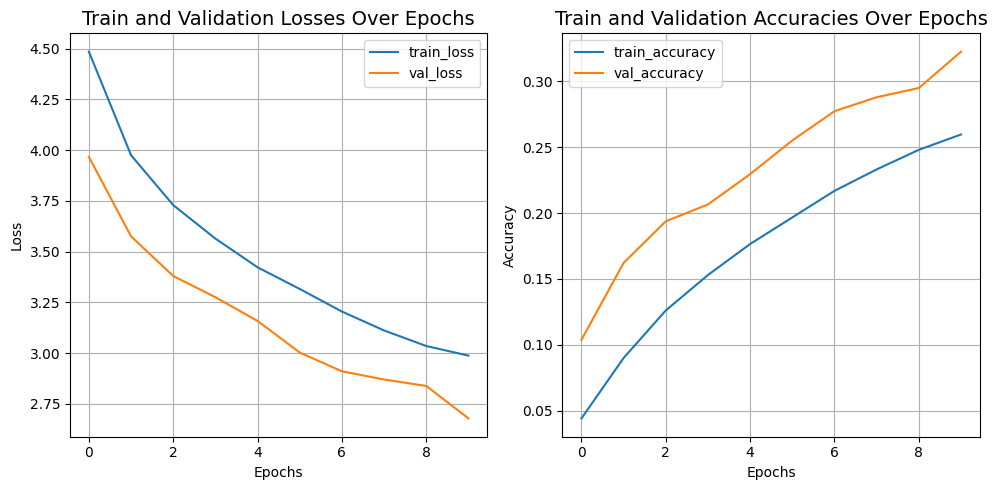

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history_2.history["loss"], label="train_loss")
ax[0].plot(history_2.history["val_loss"], label="val_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train and Validation Losses Over Epochs", fontsize=14)
ax[0].legend()
ax[0].grid()
ax[1].plot(history_2.history["accuracy"], label="train_accuracy")
ax[1].plot(history_2.history["val_accuracy"], label="val_accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Train and Validation Accuracies Over Epochs", fontsize=14)
ax[1].legend()
ax[1].grid()
fig.tight_layout()
plt.show()

In [ ]:
loss_2, accuracy_2, top_5_accuracy_2 = vit_classifier_2.evaluate(x_test, y_test)
print(f"Test loss: {round(loss_2, 2)}")
print(f"Test accuracy: {round(accuracy_2 * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy_2 * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3398 - loss: 2.6276 - top-5-accuracy: 0.6436
Test loss: 2.64
Test accuracy: 33.76%
Test top 5 accuracy: 63.78%


**1.5.2 Compute the confusion matrix**
*   Compute confusion matrix and classification summary of both the models
*   Compare both the models with respect to the computed metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
[[53  2  0 ...  0  0  0]
 [ 1 43  0 ...  0  0  0]
 [ 1  1 21 ...  3  6  0]
 ...
 [ 0  0  0 ... 45  2  0]
 [ 0  0  1 ...  0 14  0]
 [ 0  0  1 ...  0  0 37]]


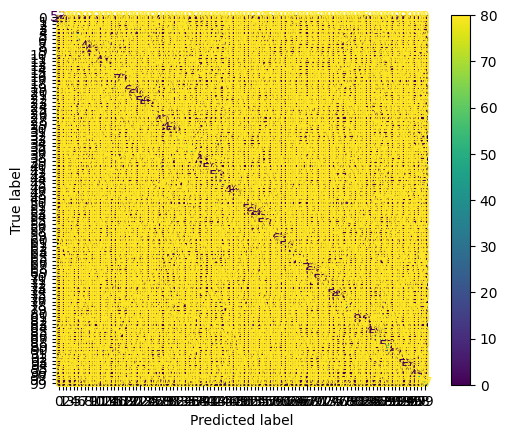

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
[[59  2  0 ...  0  0  0]
 [ 1 54  0 ...  0  1  0]
 [ 1  2 18 ...  0  6  1]
 ...
 [ 0  0  0 ... 30  0  0]
 [ 0  2  0 ...  1  9  3]
 [ 0  1  0 ...  0  0 25]]


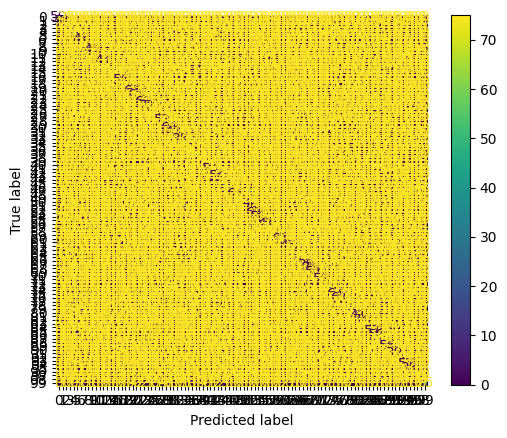

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Model 1
pred_1 = vit_classifier.predict(x_test)
pred_1 = np.argmax(pred_1, axis = 1)
cm = confusion_matrix(y_test, pred_1)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Model 2
pred_2 = vit_classifier_2.predict(x_test)
pred_2 = np.argmax(pred_2, axis = 1)
cm = confusion_matrix(y_test, pred_2)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Model 1:")
print(classification_report(y_test, pred_1))
print("\nModel 2:")
print(classification_report(y_test, pred_2))

Model 1:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       100
           1       0.48      0.43      0.46       100
           2       0.32      0.21      0.25       100
           3       0.20      0.03      0.05       100
           4       0.14      0.16      0.15       100
           5       0.28      0.34      0.31       100
           6       0.42      0.31      0.36       100
           7       0.56      0.32      0.41       100
           8       0.31      0.41      0.35       100
           9       0.60      0.42      0.49       100
          10       0.50      0.06      0.11       100
          11       0.27      0.21      0.24       100
          12       0.34      0.43      0.38       100
          13       0.32      0.32      0.32       100
          14       0.35      0.18      0.24       100
          15       0.16      0.22      0.19       100
          16       0.51      0.20      0.29       100
          17      

**Solution**

Model 1 (standard Vision Transformer) and Model 2 (Vision Transformer with Shifted Patch Tokenization) achieve similar overall accuracy (~34%), but class-wise results highlight key differences. Shifted Patch Tokenization improves local context capture, leading to better recall in classes like 20 (0.64 to 0.65) and 48 (0.53 to 0.66). Model 2 shows stronger generalization in classes such as 52, with an F1-score increase from 0.54 to 0.57. However, it slightly underperforms in precision for some classes, such as 23, where the F1-score drops from 0.61 to 0.58. Additionally, Model 2 struggles with sparse or less distinctive classes like 10, where the F1-score falls from 0.11 to 0.04. Overall, Shifted Patch Tokenization enhances recall and spatial understanding but introduces a trade-off between precision and generalization, demonstrating its effectiveness in capturing broader spatial relationships while occasionally reducing accuracy on finer details.

**Questions**   
* 1. Compare DeiT (Data-Efficient Image Transformers) with ViT.
* 2. What are the differences in both the architectures.
* 3. What is one limitation of ViT that is overcome with a DeiT?

**Solution**

* 1. Vision Transformers (ViT) and Data-Efficient Image Transformers (DeiT) share the core architecture of a transformer but in their data requirements and training methods. ViT is pretrained on large-scale  massive datasets like ImageNet-21k, whereas DeiT uses knowledge distillation to improve data efficiency. DeiT integrates a "distillation token," allowing the model to learn from both the dataset and a pre-trained "teacher" model. This reduces the model's reliance on pre-training datasets.
* 2. ViT: Uses the typical architecture of a transformer that has been adapted for image classification, where images are divided into patches are processed in a similar way to word embeddings in NLP. <br>
DeiT: Improves ViT with a distillation token that enables the model to learn from a teacher model during training. This additional token refines the model's predictions, enabling DeiT to achieve better performance especially on smaller dataset
* 3. ViT is dependent on very large datasets for training. DeiT overcomes this with knowledge distillation, which allows the model to perform well even with limited data, making it a better choice for applications with limited data availability, for example in some biomedical applications

**Questions**   
* 3. What is distillation?
* 4. Explain the distillation used in DeiT
* 5. What is its significance? Why do we need distillation?

**Solution**

* 3. Distillation in machine learning refers to knowledge distillation, a process where a smaller or more efficient model (called the "student") is trained to mimic a larger, well-performing model (the "teacher"). The teacher model generates labels or probability distributions over classes, which the student model uses to learn not only the correct classifications but also the relative probabilities of incorrect ones.
* 4. DeiT (Data-Efficient Image Transformer) incorporates an additional distillation token alongside the standard class token. During training, this token interacts with both the image data and the outputs of the teacher model . The distillation token guides the model to learn from both the ground truth and the teacher’s predictions, allowing the student model to achieve higher accuracies without the need for large amounts of training data
* 5.
  * Reduced computational cost
  * Improved data efficiency
  * Better generalisation

# 2. Train your transformer on the brain tumor dataset (5 points)

This dataset correspond to MRI brain images, labeled as *tumor* and *no tumor*. It is a very small dataset, with 98 no tumor and 155 tumor-present images.

Dataset obtained from [here](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data)

You will run over this dataset the 2 previous versions of transformers

Note: Expect accuracy results around: x%

**2.1 Load the dataset, given that is very limited, use this for train and 10% for validation. There will be no testing set for this exercise.** (0.5 points)

* Plot one image per class (1x2 grid). Make sure to mention in the title of each the class they belong to.
* Resize all images to 128x128

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow import keras

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [ ]:
import os
# Check out the directory structure

for root, dirs, files in os.walk(path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Show a sample of files
        print(f"  {file}")

Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1
Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/yes
  Y108.jpg
  Y8.jpg
  Y78.jpg
  Y186.jpg
  Y4.jpg
Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset
Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset/yes
  Y108.jpg
  Y8.jpg
  Y78.jpg
  Y186.jpg
  Y4.jpg
Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset/no
  37 no.jpg
  49 no.jpg
  22 no.jpg
  28 no.jpg
  15 no.jpg
Directory: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/no
  37 no.jpg
  49 no.jpg
  22 no.jpg
  28 no.jpg
  15 no.jpg


The dataset structure shows that there are two main folders (no and yes) that contain images for the respective labels.

In [ ]:
base_path="/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1" # Copy paste the path from kaggle

In [ ]:
no_dir = os.path.join(base_path, "no") # No tumor
yes_dir = os.path.join(base_path, "yes") # Tumor

# Define a function to load and resize images
def load_images_and_labels(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):  # We ensure it's a file
            img = cv2.imread(file_path)
            img_resized = cv2.resize(img, img_size)  # Resize to 128x128 as requested
            images.append(img_resized)
            labels.append(label)
    return images, labels

# Load images from both classes
no_tumor_images, no_tumor_labels = load_images_and_labels(no_dir, label=0)  # 0 for "No Tumor"
tumor_images, tumor_labels = load_images_and_labels(yes_dir, label=1)      # 1 for "Tumor"

# Combine images and labels
all_images = np.array(no_tumor_images + tumor_images)
all_labels = np.array(no_tumor_labels + tumor_labels)

In [ ]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.1, stratify=all_labels, random_state=42) # 10% validation

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 227
Validation set size: 26


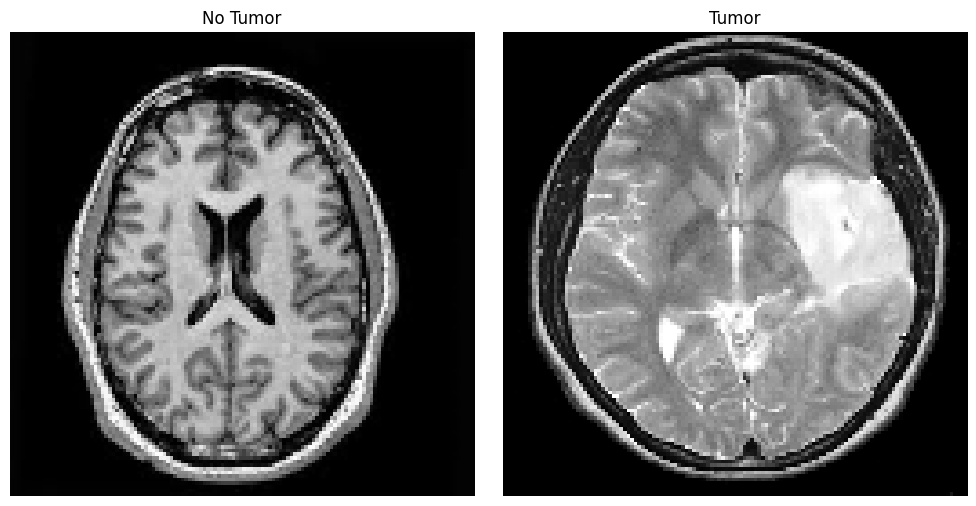

In [ ]:
# Create a 1x2 grid to display one example from each class

# First we find one example from each class
tumor_example = next(img for img, label in zip(X_train, y_train) if label == 1)
no_tumor_example = next(img for img, label in zip(X_train, y_train) if label == 0)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# No Tumor
axes[0].imshow(cv2.cvtColor(no_tumor_example, cv2.COLOR_BGR2RGB))
axes[0].set_title("No Tumor")
axes[0].axis("off")

# Tumor
axes[1].imshow(cv2.cvtColor(tumor_example, cv2.COLOR_BGR2RGB))
axes[1].set_title("Tumor")
axes[1].axis("off")

plt.tight_layout()
plt.show()


**2.2 Perform data augmentation (you can use the same logic as the previous model one). Change resizing to 256x256** (0.5 points)

In [ ]:
image_size = 256  # Update to 256x256

In [ ]:
# Reuse the previous data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size), # Ensures all input images are resized during augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [ ]:
data_augmentation.layers[0].adapt(X_train)

**2.3 Visualize the patches from this model with ShiftedPatchTokenization for one random image** (1 point)

The value for patch_size depends on the size of the input images (image_size) and the desired number of patches (num_patches). Each patch will have dimensions of patch_size x patch_size. In this case, the image_size is 256 and we set the num_patches to 64, so the patch_size will be 32.

In [ ]:
image_size=256
num_patches=64
patch_size=32

In [ ]:
# We will use this provided class

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            #Original
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=num_patches, projection_dim=projection_dim, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


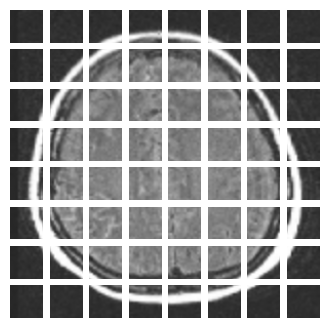

In [ ]:
# Get a random image from the training dataset
# and resize the image
image = X_train[np.random.choice(range(X_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

**2.4 Train the ViT classifier with ShiftedPatchTokenization built for this dataset.** (2 points)
* You can use 5 epochs, batch of 8, make sure your input shape is (128,128,3)
* Consider the changes you have to perform to run_experiment and create_vit_classifier_SP given that now we are working with a binary problem

In [ ]:
# Adapt hyperparameters to the ones specified
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8 # ADAPTED
num_epochs = 5 # ADAPTED
num_classes = 1 # ADAPTED
image_size = 128  # ADAPTED
input_shape = (image_size, image_size, 3) # ADAPTED
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
LAYER_NORM_EPS = 1e-6

In [ ]:
# New binary version of create_vit_classifier_SP
def create_vit_classifier_SP_binary():
    inputs = layers.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    (tokens, _) = ShiftedPatchTokenization(vanilla=True)(augmented)

    # Encode patches
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    # ***ADAPTED*** Add Sigmoid activations funtion
    logits = layers.Activation('sigmoid')(logits)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# New binary version of run_experiment_binary
def run_experiment_binary(model):
  optimizer = tf.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(from_logits=True), # APADTED
      metrics=[
          keras.metrics.BinaryAccuracy(name="accuracy"), # ADAPTED
          # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), # REMOVED
      ],
  )

  checkpoint_filepath = "/tmp/checkpoint.weights.h5"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      x=X_train, # ADAPTED
      y=y_train, # ADAPTED
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=(X_val, y_val), # ADAPTED
      callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy = model.evaluate(X_val, y_val) # ADAPTED
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%") # REMOVED

  return history

In [ ]:
vit_classifier_3 = create_vit_classifier_SP_binary()
print(vit_classifier_3.summary())
history_3 = run_experiment_binary(vit_classifier_3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 256, 256, 3)    │              7 │ input_layer_12[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shifted_patch_tokenizati… │ [(None, 64, 64),       │        196,672 │ data_augmentation[5][… │
│ (ShiftedPatchTokenizatio… │ (None, 8, 8, 3072)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_9           │ (None, 64, 64)         │          4,096 │ shifted_patch_tokeniz… │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_164   │ (None, 64, 64)         │            128 │ patch_encoder_9[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_72   │ (None, 64, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_144 (Add)             │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_165   │ (None, 64, 64)         │            128 │ add_144[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_184 (Dense)         │ (None, 64, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_244 (Dropout)     │ (None, 64, 128)        │              0 │ dense_184[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_185 (Dense)         │ (None, 64, 64)         │          8,256 │ dropout_244[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_245 (Dropout)     │ (None, 64, 64)         │              0 │ dense_185[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_145 (Add)             │ (None, 64, 64)         │              0 │ dropout_245[0][0],     │
│                           │                        │                │ add_144[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_166   │ (None, 64, 64)         │            128 │ add_145[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_

 Total params: 11,356,360 (43.32 MB)

 Trainable params: 11,356,353 (43.32 MB)

 Non-trainable params: 7 (32.00 B)

None
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.6540 - loss: 3.3490 - val_accuracy: 0.7692 - val_loss: 1.0506
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.5939 - loss: 2.6050 - val_accuracy: 0.8462 - val_loss: 0.3761
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6443 - loss: 1.7858 - val_accuracy: 0.8846 - val_loss: 0.3967
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7034 - loss: 1.4083 - val_accuracy: 0.8846 - val_loss: 0.2138
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6622 - loss: 1.4318 - val_accuracy: 0.8846 - val_loss: 0.3508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8846 - loss: 0.3967
Test accuracy: 88.46%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[ 8  2]
 [ 1 15]]


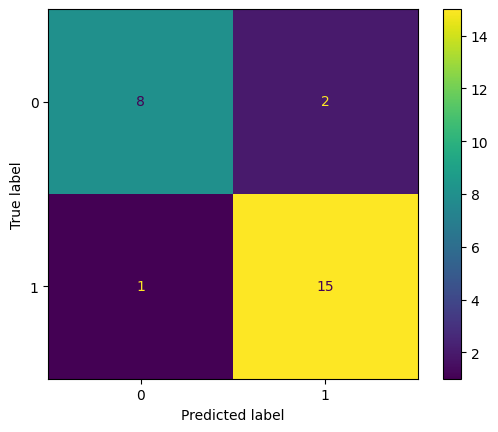

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Model 3
pred_3 = vit_classifier_3.predict(X_val)
pred_3 = np.round(pred_3).tolist()
cm = confusion_matrix(y_val, pred_3)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Model 3:")
print(classification_report(y_val, pred_3))

Model 3:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.88      0.94      0.91        16

    accuracy                           0.88        26
   macro avg       0.89      0.87      0.88        26
weighted avg       0.88      0.88      0.88        26



**2.5 Predict one in the validation set and show results: both the original label, the predicted one and the image** (1 point)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


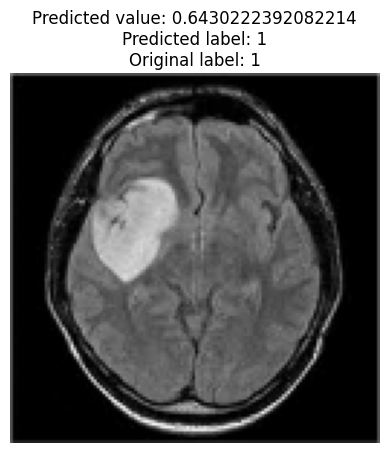

In [ ]:
# Predict one in the validation set and show results: both the original label, the predicted one and the image
index_for_predict = 3
image_to_predict = X_val[index_for_predict]
predict_true = vit_classifier_3.predict(np.expand_dims(image_to_predict, axis=0))
predict = [[int(i) for i in sublist] for sublist in np.round(predict_true).tolist()]
title = f"Predicted value: {predict_true[0][0]}\n"
title += f"Predicted label: {predict[0][0]}\n"
title += f"Original label: {y_val[index_for_predict]}"
plt.imshow(image_to_predict)
plt.title(title)
plt.axis('off')
plt.show()


---

## **End of Part 1: Go to 08_lab_transformers_part2**
